In [4]:
%matplotlib inline


训练一个分类器
=====================


数据呢?
----------------

通常，当必须处理图像、文本、音频或视频数据时，可以使用标准python包将数据加载到numpy数组中。<br>
将其转换成 ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

视觉方面很特别, 我们创建了一个专门的工具包<br>
``torchvision``, 它具有用于公共数据集(例如)的数据加载器<br>
Imagenet, CIFAR10, MNIST等。以及用于图像的数据转换器。<br>
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

这提供了极大的便利，避免了编写样板代码。<br>

在本教程中，我们将使用CIFAR10数据集。<br>
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,<br>
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of<br>
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.<br>

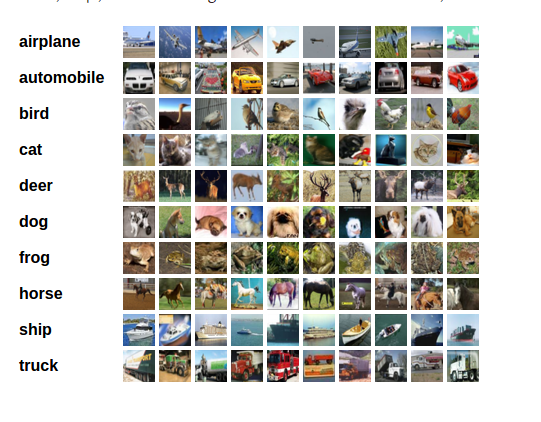


Training an image classifier
----------------------------

我们将按照以下步骤进行:

1. 加载和规范CIFAR10培训和测试数据集
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

## 1. Loading and normalizing CIFAR10


Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision数据集的输出为range[0,1]的PILImage图像。<BR>
我们把它们转换成归一化范围[- 1,1]的张量。


-[transforms.Compose归一化到[-1.0, 1.0]](https://blog.csdn.net/hao5335156/article/details/80593349)

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████████████████████████████████████████████████████████▉| 170450944/170498071 [02:14<00:00, 1624401.24it/s]

Files already downloaded and verified


170500096it [02:30, 1624401.24it/s]                                                                                    

Let us show some of the training images, for fun.



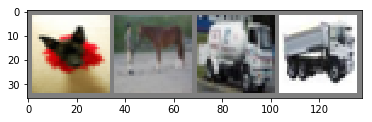

  dog horse truck truck


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取一些训练图像
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

从前面的神经网络部分复制神经网络，并将其修改为<br>
取3通道图像(而不是之前定义的1通道图像).



In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy(分类交叉熵损失)ss and SGD with momentum.

In [8]:
import torch.optim as optim  

criterion = nn.CrossEntropyLoss()# 之前是RMSE   criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

这是事情开始变得有趣的时候。<BR>
我们只需遍历数据迭代器，并将输入输入到网络并进行优化。


In [9]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.172
[1,  4000] loss: 1.861
[1,  6000] loss: 1.661
[1,  8000] loss: 1.569
[1, 10000] loss: 1.498
[1, 12000] loss: 1.448
[2,  2000] loss: 1.393
[2,  4000] loss: 1.354
[2,  6000] loss: 1.363
[2,  8000] loss: 1.325
[2, 10000] loss: 1.318
[2, 12000] loss: 1.310
Finished Training


## 5. Test the network on the test data


我们对网络进行了两次遍历训练数据集的训练。<BR>
但我们需要检查该网络是否有所收获。<BR>

我们将通过预测神经网络输出的类标签来检查这一点，<BR>
并根据基本事实来检查它。如果预测是正确的，我们将样本添加到正确预测列表中。<BR>

好的,第一步。让我们从测试集中显示一个图像来熟悉它。



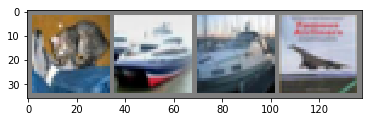

GroundTruth:    cat  ship  ship plane


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

好了，现在让我们看看神经网络是怎么想的上面这些例子是:



In [11]:
outputs = net(images)

The outputs are energies for the 10 classes.<BR>
The higher the energy for a class, the more the network<BR>
thinks that the image is of the particular class.<BR>
So, let's get the index of the highest energy:<BR>



In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


这看起来比随机抽取10%的正确率(从10个类中随机抽取一个类)要好得多。
看来网络学到了一些东西。

嗯，哪些类执行得好，哪些类执行得不好:



In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 72 %
Accuracy of  bird : 33 %
Accuracy of   cat : 41 %
Accuracy of  deer : 46 %
Accuracy of   dog : 34 %
Accuracy of  frog : 62 %
Accuracy of horse : 62 %
Accuracy of  ship : 68 %
Accuracy of truck : 61 %


Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


本节的其余部分假设 ``device`` 是一个CUDA设备。

然后这些方法将递归遍历所有模块，并将它们的参数和缓冲区转换为CUDA张量:



   ___net.to(device)___


记住每一步的输入输出也要放入GPU中：

<code> inputs, labels = inputs.to(device), labels.to(device)</code>
        

为什么我没有注意到与CPU相比的巨大加速?因为你的网络实在是太小了。

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- 高层次地理解PyTorch张量库和神经网络.
- 训练一个小的神经网络对图像进行分类

Training on multiple GPUs
-------------------------
如果你想看到更大的加速使用你所有的gpu
 -[data_parallel_tutorial](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html)

Where do I go next?
-------------------

-  -[训练神经网络玩电子游戏](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
-  [在imagenet上训练最先进的ResNet网络](https://github.com/pytorch/examples/tree/master/imagenet)
-  [使用可生成的对抗网络训练人脸生成器(GAN)](https://github.com/pytorch/examples/tree/master/dcgan)
-  [使用递归LSTM网络训练单词级语言模型](https://github.com/pytorch/examples/tree/master/word_language_model)
-  [更多例子](https://github.com/pytorch/examples)
-  [更多教程_](https://github.com/pytorch/tutorials)
-  [在论坛上讨论PyTorch](https://discuss.pytorch.org/)



